# commentare il programma

# Fase 1: mappare il problema sul circuito e sugli operatori

## Definisco il canale Amplitude Damping

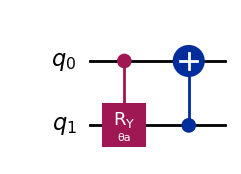

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import CRYGate
from qiskit.circuit import Parameter, ParameterVector
import numpy as np

def amplitude_damping_gate(theta_val):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping
    su due qubit (sistema e ambiente).

    Parametri:
        theta_val (float or Parameter): angolo per la rotazione Ry

    Restituisce:
        Gate: un gate personalizzato da applicare a 2 qubit
    """
    theta = Parameter('θa') if isinstance(theta_val, Parameter) else theta_val
    # Crea un circuito con 2 qubit: qubit 0 = S_1, qubit 1 = E_1 (Ambiente)
    qc = QuantumCircuit(2, name="Amplitude Damping Model")

    # Applicazione delle porte
    # Applica una porta controllata-RY(θ)
    qc.cry(theta ,0 ,1 )# controllo su qubit 0 (S1), target qubit 1 (E1)
    qc.cx(1, 0)              # CNOT: controllo E_1 (qubit 1), target S_1 (qubit 0)

    # Converte in un Custom Gate
    gate = qc.to_gate(label="AmpDamp")
    return gate

theta = Parameter('θa')
example = QuantumCircuit(2)
damp_gate = amplitude_damping_gate(theta)
example.append(damp_gate, [0 ,1])
example.decompose().draw("mpl")


## Definisco il canale per calcolare l'error rate

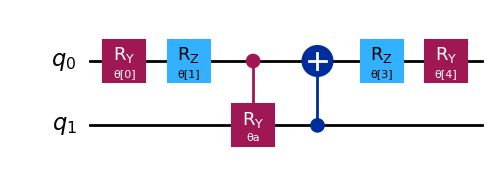

In [3]:

# definisco un vettore di parametri simbolici parametro simbolico
thetas = ParameterVector('θ', 5)

# Crea un circuito con 2 qubit: qubit 0 = S_1, qubit 1 = E_1
qc = QuantumCircuit(2, name="Amplitude Damping Model")

# Applicazione delle porte

# Applica una porta RY()
qc.ry(thetas[0], 0)

# Applica una porta RZ()
qc.rz(thetas[1], 0)

# Applica il canale Amplitude Damping con parametrizza con thetas[2]
damp_gate = amplitude_damping_gate(thetas[2])
qc.append(damp_gate, [0, 1])

# Applica una porta RZ()
qc.rz(thetas[3], 0)

# Applica una porta RY()
qc.ry(thetas[4], 0)

# Visualizza il circuito
qc.draw('mpl')

qc.decompose("AmpDamp").draw("mpl")
#print(qc.parameters) #permette di mostrare tutti i parametri non definiti

## Definisco lo stato iniziare del circuito nella forma di matrice densità parametrizzata

In [ ]:
from qiskit.quantum_info import DensityMatrix
from numpy import array
from qiskit.visualization import plot_state_qsphere
def initial_state_diagonal_real_density_matrix(_alpha):
    # Parametro di mescolanza
    alpha = _alpha

    #creo una matrice in forma array[array[,...],...]
    rho_0_matrix = array([[1 - alpha, 0],
                [0, alpha]])
    
    # Creo lo stato misto da rho_0_matrix per qubit 0
    rho_0 = DensityMatrix(rho_0_matrix)

    # creo lo stao del qubit 1 (ambiente) in |0>
    rho_1 = DensityMatrix.from_label('0')

    # Stato iniziale totale a 2 qubit
    rho_init = rho_0.tensor(rho_1)

    return rho_init
